In [19]:
from rdkit import Chem
from catemb.data import CatDataset
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

In [2]:
dataset = CatDataset(root='./dataset/processed',name="lig_cat_dataset_xtbopt_new_62755",read_coord=True,save_smiles=True)
full_dataset = np.load("./dataset/processed/lig_cat_dataset_new.npy",allow_pickle=True)
smiles_with_opt_lst = [data.smiles for data in dataset]
mol_with_opt_lst = [Chem.MolFromSmiles(smi) for smi in smiles_with_opt_lst]
smiles_without_opt_lst = [data['smiles'] for data in full_dataset]
mol_without_opt_lst = [Chem.MolFromSmiles(smi) for smi in smiles_without_opt_lst]

In [3]:
cat_smi_metal_without_opt_map = {}
orig_lig_cat_smi_without_opt_lst = []
for smi, mol in zip(smiles_without_opt_lst, mol_without_opt_lst):
    dative_bonds = [bond for bond in mol.GetBonds() if bond.GetBondType() == Chem.rdchem.BondType.DATIVE]
    if len(dative_bonds) > 0:
        metal_symbol = dative_bonds[0].GetEndAtom().GetSymbol()
        cat_smi_metal_without_opt_map[smi] = metal_symbol
    else:
        orig_lig_cat_smi_without_opt_lst.append(smi)
len(orig_lig_cat_smi_without_opt_lst),len(cat_smi_metal_without_opt_map)

(12797, 53867)

In [4]:
ligand_smarts_type_map = {'P-[#6,#7]~[#6]-[C;H0]1=N[C,c][C,c]O1':"PHOX",
                          'P-[#6,#7]~[#6]~[#6]-[C;H0]1=N[C,c][C,c]O1':"PHOX",
                          'P-[#6,#7]~[#6]~[#6]~[#6]-[C;H0]1=N[C,c][C,c]O1':"PHOX",
                          'P-[#6,#7]~[#6]~[#6]~[#6]~[#6]-[C;H0]1=N[C,c][C,c]O1':"PHOX",
                          'O=[SX3]([*:4])[N]([*:3])[C]([H])([*:1])([*:2]).[PX3]([#6])([#6])':"SadPhos",
                          '[*][SX3](N([*])[CX4;!R]([*])C1=CC=CC=C1[PX3]([#6])([#6]))=O':"SadPhos",
                          '[*][CX4;!R]([CX4;!R][PX3]([#6])[#6])N([*])[S@@X3]([*])=O':"SadPhos",
                          '[*]C1([*])C2=C(C([CX4;!R]([*])N(*)[S@@X3]([*])=O)=CC=C2)OC3=C([PX3]([#6])([#6]))C=CC=C31':"SadPhos",
                          'PccCN([*])[S@@X3]([*])=O':"SadPhos",
                          'O1[C,c][C,c]N=[C]1~[#6]~[C]2=N[C,c][C,c]O2':"Box",
                          'O1[C,c][C,c]N=[C]1~[c]~[n]~[c]~[C]2=N[C,c][C,c]O2':"Box",
                          'O1[C,c][C,c]N=[C]1~[c]~[c]~[c]~[c]~[C]2=N[C,c][C,c]O2':"Box",
                          'O-c1ccccc1-C=[N,n]~[#6]~[#6]~[N,n]=C-c2ccccc2O':"Salen",
                          '[P]~[#6,c]~[P]':"Bisphos",
                          '[P]~[#6,c]~[#6,c]~[P]':"Bisphos",
                          '[P]~[#6,c]~[#6,c]~[#6,c]~[P]':"Bisphos",
                          '[P]~[#6,c]~[#6,c]~[#6,c]~[#6,c]~[P]':"Bisphos",
                          'P-c1c2ccccc2ccc1-c3c(P)ccc4ccccc34':"Bisphos",
                          'PC12C3C4C5C1[Fe]25436789C%10C6C7C8C%109P':"Bisphos",
                          '[P;H0](-[#6])([-#6])-[#6]~[#6]~[P;H0](-[#6])-[#6]':"Bisphos",
                          "[P]-[N]-[c]~[c]~[c]~[c]-[N]-[P]":'Bisphos',
                          "[P]-[c]~[c]-[C]-[C]-[c]~[c]~[c]-[P]":'Bisphos',
                          "[P]-[c]~[c]~[A]~[c]~[c]-[P]":'Bisphos',
                          '[n,N,n+,N+]1~[c,C;H1]~[n,N,n+,N+]~[c,C]~[c,C]1':"NHC",
                          '[P;X3;H0;v3;!$(P=[O,S,N])](-[#6,c])(-[#6,c])-[#6,c]':"Monophos",
                          '[O-][N+]1(CCCCC1C=O)CCC[N+]2(C(C=O)CCCC2)[O-]':"N,N-Dioxide",
                          '[O-][N+]1(CCC[N+]2([O-])CCCC2C=O)CCCC1C=O':"N,N-Dioxide",
                          '[N][CX4][C](=[O])[O;H1]':"amino acid",
                          '[N][CX4][C](=[O])[O;H0-]':"amino acid",
                          '[P;X4;v5](=[O])([O;H1,H0-])([O,o])([O,o])':'Phos acid'
                          }
ligand_smarts_mol_map = {smarts:Chem.MolFromSmarts(smarts) for smarts in ligand_smarts_type_map}

In [5]:
lig_smi_type_map = {}
lig_smi_nometal_lst = []
for smi in orig_lig_cat_smi_without_opt_lst:
    mol = Chem.MolFromSmiles(smi)

    for smarts, type_ in ligand_smarts_type_map.items():
        scaffold_mol = ligand_smarts_mol_map[smarts]
        if mol.HasSubstructMatch(scaffold_mol):
            if not smi in lig_smi_type_map:
                lig_smi_type_map[smi] = [type_]
            else:
                if 'Bisphos' in lig_smi_type_map[smi] and type_ == 'Monophos':
                    continue
                lig_smi_type_map[smi].append(type_)
        
lig_type_smi_map = {}
for smi in lig_smi_type_map:
    for type_ in lig_smi_type_map[smi]:
        if not type_ in lig_type_smi_map:
            lig_type_smi_map[type_] = [smi]
        else:
            lig_type_smi_map[type_].append(smi)
lig_type_count_map = {}
for type_ in lig_type_smi_map:
    lig_type_count_map[type_] = len(lig_type_smi_map[type_])


In [7]:
metal_lst = list(cat_smi_metal_without_opt_map.values())
metal_ct_lst = sorted([[metal, metal_lst.count(metal)] for metal in set(metal_lst)], key=lambda x: x[1], reverse=True)
print("\n".join([",".join([item[0],str(item[1])]) for item in metal_ct_lst]))

Pd,13866
Ni,12195
Cu,7916
Rh,7432
Ru,5016
Au,2755
Ir,881
Fe,862
Zn,622
Co,482
Mn,304
Sn,253
Ag,100
Tm,65
Y,65
Dy,65
Tb,65
Ce,65
Ho,65
Sc,65
Gd,65
Er,65
Sm,65
Mg,65
Ba,65
Pr,65
La,65
Eu,65
Nd,65
Lu,65
Yb,65
Ti,13


In [8]:
from catemb import CatEmb
from catemb.utils import set_seed
from sklearn.manifold import TSNE
set_seed(42)
lig_type_color_map = {'Monophos': 'lightcoral',
 'Bisphos': 'saddlebrown',
 'SadPhos': 'darkorange',
 'PHOX': 'lightgreen',
 'NHC': 'green',
 'amino acid': 'navy',
 'Salen': 'deepskyblue',
 'Box': 'pink',
 'Phos acid': 'orchid',
 'N,N-Dioxide':'gray'}
model_path = './catemb/model_path/dim32LN'
catemb_calc = CatEmb(model_path=model_path, device='cpu')

In [11]:
sel_lig_smi_lst = []
sel_lig_type_lst = []
for smi in lig_smi_type_map:
    type_ = lig_smi_type_map[smi][0]
    sel_lig_smi_lst.append(smi)
    sel_lig_type_lst.append(type_)
    
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
lig_desc = catemb_calc.gen_desc(sel_lig_smi_lst)
lig_tsne = tsne.fit_transform(lig_desc)

In [14]:
X = deepcopy(lig_tsne)
lig_type_x_map = {}
lig_type_idx_map = {}
for idx in range(len(sel_lig_smi_lst)):
    x = X[idx]
    smi = sel_lig_smi_lst[idx]
    type_ = lig_smi_type_map[smi][0]
    if not type_ in lig_type_x_map:
        lig_type_x_map[type_] = [x]
        lig_type_idx_map[type_] = [idx]
    else:
        lig_type_x_map[type_].append(x)
        lig_type_idx_map[type_].append(idx)
lig_type_x_map = {type_: np.array(x_lst) for type_, x_lst in lig_type_x_map.items()}

86.01818 -78.48043 71.11848 -78.55964


(-88.55963897705078, 81.11847686767578)

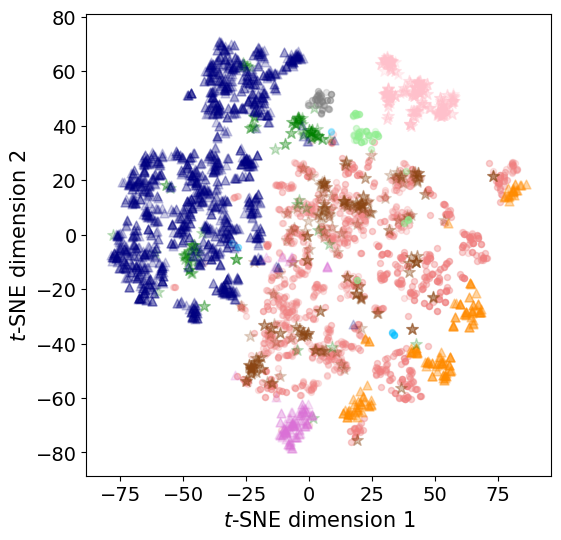

In [18]:
label_fontsize = 15
tick_fontsize = 14
ct = 0
maker_type = ['.','*',"^"]
maker_size = [75,75,40]
lig_type_ave_x_map = {}
plt.figure(figsize=(6,6))
x_max = 0
x_min = 0
y_max = 0
y_min = 0
for idx,type_ in enumerate(lig_type_color_map.keys()):
    x_lst = lig_type_x_map[type_]
    
    plt.scatter(x_lst[:,0],x_lst[:,1],color=lig_type_color_map[type_],label=type_,alpha=0.2,marker=maker_type[idx%3],s=maker_size[idx%3])
    ave_0 = np.mean(x_lst[:,0])
    ave_1 = np.mean(x_lst[:,1])
    #plt.scatter(ave_0,ave_1,color=lig_type_color_map[type_],label=type_+' ave',s=maker_size[idx%2],marker=maker_type[idx%2],edgecolors='gray')
    lig_type_ave_x_map[type_] = np.array([ave_0,ave_1])
    x_max = max(x_max,np.max(x_lst[:,0]))
    x_min = min(x_min,np.min(x_lst[:,0]))
    y_max = max(y_max,np.max(x_lst[:,1]))
    y_min = min(y_min,np.min(x_lst[:,1]))
print(x_max,x_min,y_max,y_min)

plt.xlabel("$\tt$-SNE dimension 1",fontsize=label_fontsize)
plt.ylabel("$\tt$-SNE dimension 2",fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.xlim([x_min-10,x_max+10])
plt.ylim([y_min-10,y_max+10])
#plt.legend(loc=(1.05,0))

Monophos 40.63 %, sample num: 1941


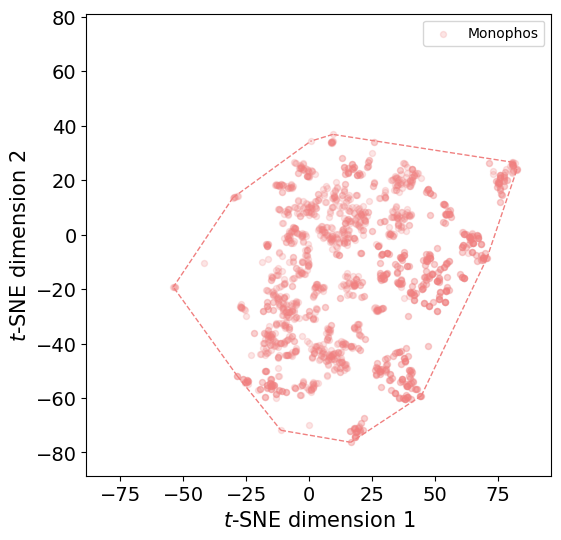

Bisphos 27.34 %, sample num: 283


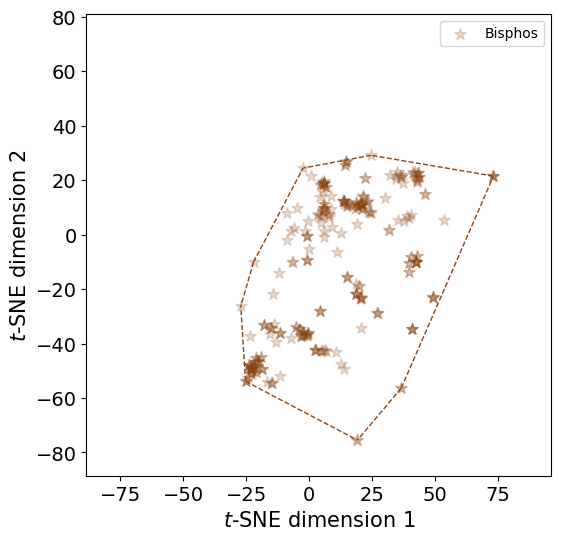

SadPhos 10.22 %, sample num: 316


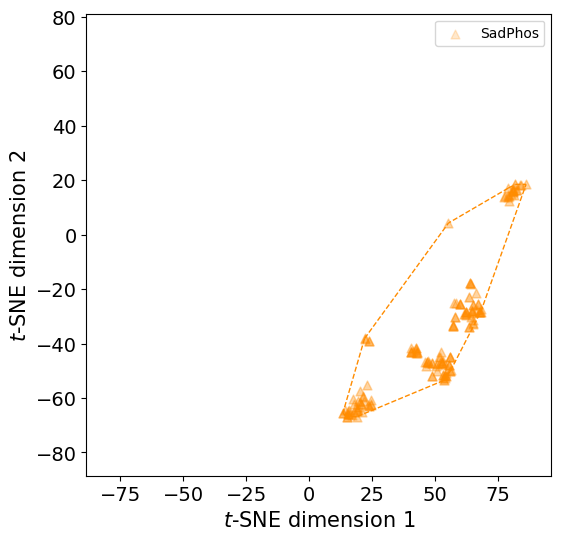

PHOX 3.43 %, sample num: 100


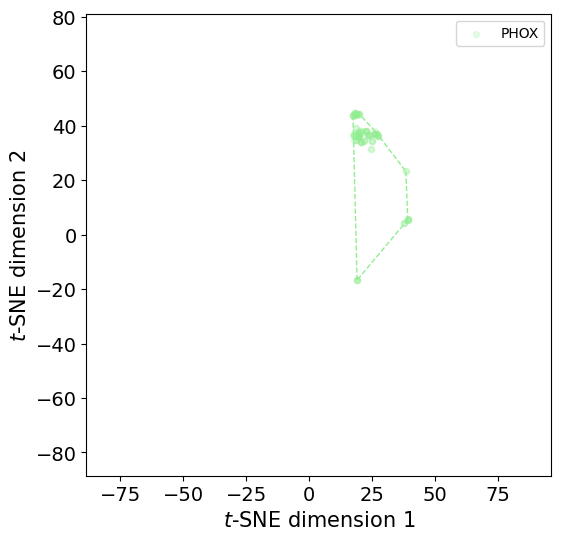

NHC 34.19 %, sample num: 113


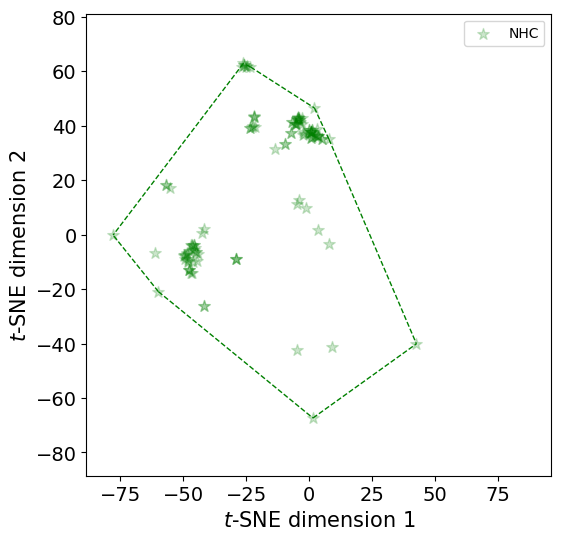

amino acid 30.36 %, sample num: 1617


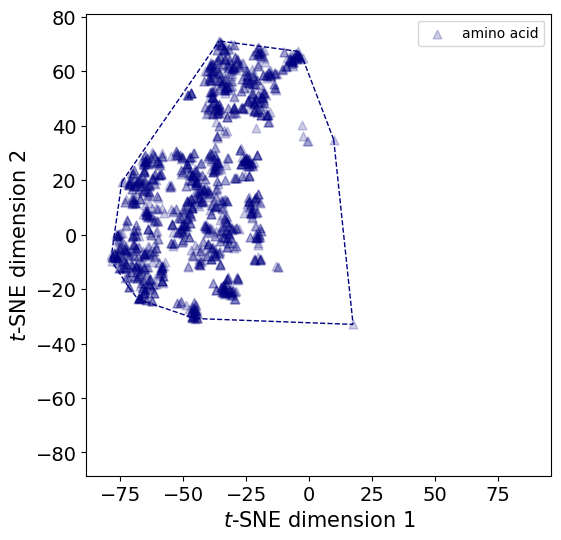

Salen 8.09 %, sample num: 14


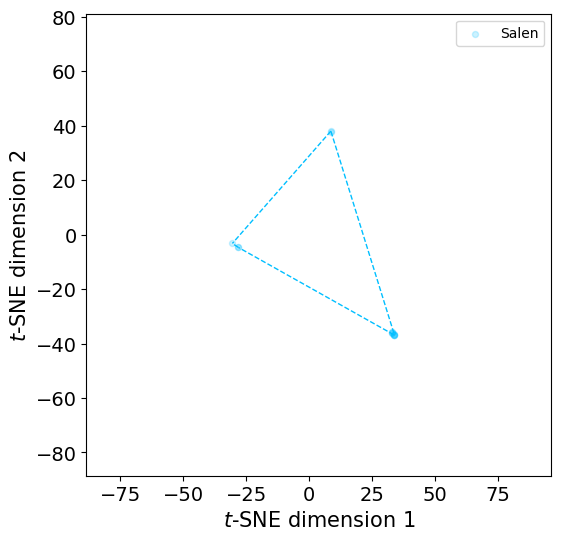

Box 1.87 %, sample num: 253


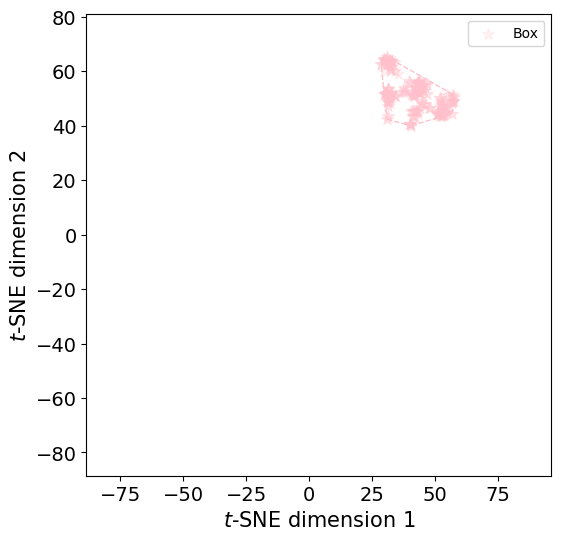

Phos acid 6.93 %, sample num: 125


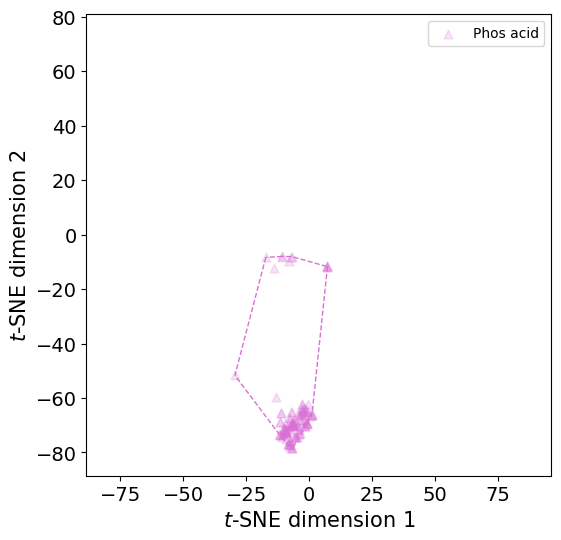

N,N-Dioxide 0.20 %, sample num: 65


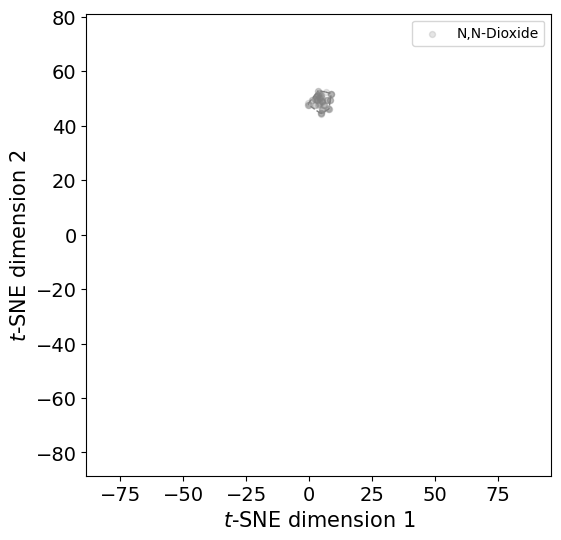

In [20]:
ct = 0
maker_type = ['.','*',"^"]
maker_size = [75,75,40]
lig_type_ave_x_map = {}
whole_space_area = (x_max-x_min)*(y_max-y_min)
for idx,type_ in enumerate(lig_type_color_map.keys()):
    plt.figure(figsize=(6,6))
    x_lst = lig_type_x_map[type_]
    hull = ConvexHull(x_lst)
    hull_area = hull.volume
    for simplex in hull.simplices:
        plt.plot(x_lst[simplex, 0], x_lst[simplex, 1],  '--', color=lig_type_color_map[type_], linewidth=1, label='Convex Hull' if simplex is hull.simplices[0] else "")
    plt.scatter(x_lst[:,0],x_lst[:,1],color=lig_type_color_map[type_],label=type_,alpha=0.2,marker=maker_type[idx%3],s=maker_size[idx%3])
    ave_0 = np.mean(x_lst[:,0])
    ave_1 = np.mean(x_lst[:,1])
    #plt.scatter(ave_0,ave_1,color=lig_type_color_map[type_],label=type_+' ave',s=maker_size[idx%2],marker=maker_type[idx%2],edgecolors='gray')
    lig_type_ave_x_map[type_] = np.array([ave_0,ave_1])
    plt.xlabel("$\tt$-SNE dimension 1",fontsize=label_fontsize)
    plt.ylabel("$\tt$-SNE dimension 2",fontsize=label_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    plt.xlim([x_min-10,x_max+10])
    plt.ylim([y_min-10,y_max+10])
    plt.legend()
    print(type_,f"{hull_area/whole_space_area*100:.2f} %, sample num: {len(x_lst)}")
    plt.show()